In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import torch, json
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet50, vgg16
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.datasets import ImageFolder
import torch.backends.cudnn as cudnn

from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
# Define custom dataset
class FaceDataset(Dataset):
    def __init__(self, dataset, transform, num_classes):
        self.dataset = dataset
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        return self.transform(img), label

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Enable GPU acceleration if available
if torch.cuda.is_available():
    cudnn.benchmark = True
device

device(type='cuda')

In [5]:
BATCH_SIZE = 32

TARGET_SIZE = 224
TARGET_SHAPE = (TARGET_SIZE, TARGET_SIZE)

ROOT_DIR = "/home/avinash/Downloads/dataset/ji-faces"

# Define data transformations
TRAIN_TRANSFORM = transforms.Compose([
    transforms.Resize(TARGET_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

VAL_TRANSFORM = transforms.Compose([
    transforms.Resize(TARGET_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [15]:
main_data = ImageFolder(ROOT_DIR)
num_classes = np.unique(main_data.classes).size

split_ratio = 0.8  # 80% for training, 20% for testing
dataset_size = len(main_data)
train_size = int(split_ratio * dataset_size)
test_size = dataset_size - train_size

# Use random_split to split the dataset
train_set, val_set = random_split(main_data, [train_size, test_size])

# Create dataset and dataloader
train_dataset = FaceDataset(train_set, transform=TRAIN_TRANSFORM, num_classes=num_classes)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True )

val_dataset = FaceDataset(val_set, transform=VAL_TRANSFORM, num_classes=num_classes)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False )

In [19]:
idx_class_map = {int(v):k for k, v in main_data.class_to_idx.items()}

In [21]:
with open("/home/avinash/Downloads/dataset/labels.json", 'w') as f:
    json.dump(idx_class_map, f)
    f.close()

# Plot Loss and Accuracy

In [22]:
def plot_model(entries, graph_type, file_path):
    train_values = [x['train'] for x in entries]
    eval_values = [x['val'] for x in entries]
    
    plt.plot(train_values,'-o')
    plt.plot(eval_values,'-o')
    plt.xlabel('Epoch')
    plt.ylabel(graph_type)
    plt.legend(['Train','Valid'])
    plt.title(f'Train vs Valid {graph_type}')
    plt.savefig(file_path)
    plt.show()

# Model Parent

In [35]:
class ParentModel(nn.Module):
    def __init__(self, num_classes, device):
        super(ParentModel, self).__init__()
        self.num_classes = num_classes
        self._device = device
        
    def setup(self, lr):
        self.cnn = self.build_model()
        self.model = nn.DataParallel(self.cnn, device_ids=list(range(torch.cuda.device_count())))
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=5, verbose=True)
        
    def build_model(self):
        raise NotImplementedError()
    
    def _train_fn(self, train_dataloader):
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Training phase
        self.model.train()
        for images, labels in tqdm(train_dataloader, bar_format="\033[31m{bar}\033[0m{percentage:3.0f}%|{n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]"):
            images = images.to(self._device)
            labels = labels.to(self._device)

            self.optimizer.zero_grad()

            outputs = self.model(images)
            loss = self.criterion(outputs, labels)

            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item() / num_classes

        train_accuracy = 100.0 * train_correct / train_total
        train_loss /= len(train_dataloader)
        return train_accuracy, train_loss
    
    def _val_fn(self, val_dataloader):
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        self.model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_dataloader, bar_format="\033[32m{bar}\033[0m{percentage:3.0f}%|{n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]"):
                images = images.to(self._device)
                labels = labels.to(self._device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item() / num_classes

        val_accuracy = 100.0 * val_correct / val_total
        val_loss /= len(val_dataloader)
        return val_accuracy, val_loss
    
    def predict(self, X):
        y_pred = []
        with torch.no_grad():
            for image in X:
                image = image.to(self._device)
                output = self.model(image)
                _, pred = output.max(1)
                y_pred.append(pred)
        return y_pred
    
    def fit(self, train_loader, val_loader, ckpt_path, patience=10):
        # Initialize variables for early stopping
        best_val_loss = float('inf')
        best_epoch = 0
        epochs_without_improvement = 0

        accuracies = []
        losses = []

        early_stop = False
        epoch = 1
        while not early_stop:
            train_accuracy, train_loss = self._train_fn(train_loader)
            val_accuracy, val_loss = self._val_fn(val_loader)
            
            self.scheduler.step(val_loss)
            accuracies.append({'train': train_accuracy, 'val': val_accuracy})
            losses.append({'train': train_loss, 'val': val_loss})
            
            # Print epoch results
            print(f"Epoch {epoch}")
            print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")
            
            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.state_dict(), ckpt_path)
                best_epoch = epoch
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement == patience:
                    print(f"No improvement for {patience} epochs. Early stopping...")
                    early_stop = True
            epoch += 1
        return accuracies, losses

# Resnet50 Classifier

In [36]:
class ResnetModel(ParentModel):
    def __init__(self, num_classes, device):
        super(ResnetModel, self).__init__(num_classes, device)
        pass

    def build_model(self):
        cnn = resnet50(weights='IMAGENET1K_V2')
        cnn.fc = nn.Linear(cnn.fc.in_features, self.num_classes)
        return cnn.to(self._device)

In [37]:
# Set hyperparameters
learning_rate = 0.001
num_epochs = 100
patience = 10  # Number of epochs to wait for improvement before early stopping

In [38]:
resnet_model = ResnetModel(num_classes, device)
resnet_model.setup(learning_rate)
resnet_model.to(device)

resnet_accuracies, resnet_losses = resnet_model.fit(train_dataloader, val_dataloader, "/home/avinash/Downloads/dataset/resnet_classifier.pth")

██████████100%|97/97 [00:26<00:00,  3.60it/s]
██████████100%|25/25 [00:03<00:00,  7.15it/s]


Epoch 1
Train Loss: 3.3173 | Train Accuracy: 0.24%
Val Loss: 2.4348 | Val Accuracy: 0.40%


██████████100%|97/97 [00:26<00:00,  3.66it/s]
██████████100%|25/25 [00:03<00:00,  6.89it/s]


Epoch 2
Train Loss: 1.2647 | Train Accuracy: 0.59%
Val Loss: 1.4971 | Val Accuracy: 0.54%


██████████100%|97/97 [00:26<00:00,  3.60it/s]
██████████100%|25/25 [00:03<00:00,  6.97it/s]


Epoch 3
Train Loss: 0.4928 | Train Accuracy: 0.74%
Val Loss: 0.8586 | Val Accuracy: 0.69%


██████████100%|97/97 [00:26<00:00,  3.67it/s]
██████████100%|25/25 [00:03<00:00,  7.21it/s]


Epoch 4
Train Loss: 0.2596 | Train Accuracy: 0.79%
Val Loss: 0.8337 | Val Accuracy: 0.70%


██████████100%|97/97 [00:26<00:00,  3.66it/s]
██████████100%|25/25 [00:03<00:00,  7.27it/s]


Epoch 5
Train Loss: 0.1743 | Train Accuracy: 0.80%
Val Loss: 0.5509 | Val Accuracy: 0.74%


██████████100%|97/97 [00:26<00:00,  3.70it/s]
██████████100%|25/25 [00:03<00:00,  7.15it/s]


Epoch 6
Train Loss: 0.0899 | Train Accuracy: 0.82%
Val Loss: 0.6049 | Val Accuracy: 0.74%


██████████100%|97/97 [00:26<00:00,  3.69it/s]
██████████100%|25/25 [00:03<00:00,  7.22it/s]


Epoch 7
Train Loss: 0.0527 | Train Accuracy: 0.83%
Val Loss: 0.4762 | Val Accuracy: 0.76%


██████████100%|97/97 [00:26<00:00,  3.62it/s]
██████████100%|25/25 [00:03<00:00,  6.72it/s]


Epoch 8
Train Loss: 0.0606 | Train Accuracy: 0.83%
Val Loss: 0.5855 | Val Accuracy: 0.73%


██████████100%|97/97 [00:27<00:00,  3.54it/s]
██████████100%|25/25 [00:03<00:00,  6.83it/s]


Epoch 9
Train Loss: 0.0768 | Train Accuracy: 0.82%
Val Loss: 0.8217 | Val Accuracy: 0.71%


██████████100%|97/97 [00:26<00:00,  3.61it/s]
██████████100%|25/25 [00:03<00:00,  6.75it/s]


Epoch 10
Train Loss: 0.1026 | Train Accuracy: 0.82%
Val Loss: 1.1270 | Val Accuracy: 0.65%


██████████100%|97/97 [00:26<00:00,  3.64it/s]
██████████100%|25/25 [00:03<00:00,  6.95it/s]


Epoch 11
Train Loss: 0.0881 | Train Accuracy: 0.82%
Val Loss: 0.5404 | Val Accuracy: 0.75%


██████████100%|97/97 [00:26<00:00,  3.62it/s]
██████████100%|25/25 [00:03<00:00,  7.15it/s]


Epoch 12
Train Loss: 0.0616 | Train Accuracy: 0.83%
Val Loss: 0.6045 | Val Accuracy: 0.74%


██████████100%|97/97 [00:26<00:00,  3.64it/s]
██████████100%|25/25 [00:03<00:00,  6.83it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13
Train Loss: 0.0669 | Train Accuracy: 0.82%
Val Loss: 0.5828 | Val Accuracy: 0.74%


██████████100%|97/97 [00:27<00:00,  3.58it/s]
██████████100%|25/25 [00:03<00:00,  6.46it/s]


Epoch 14
Train Loss: 0.0254 | Train Accuracy: 0.84%
Val Loss: 0.4203 | Val Accuracy: 0.76%


██████████100%|97/97 [00:27<00:00,  3.52it/s]
██████████100%|25/25 [00:03<00:00,  6.66it/s]


Epoch 15
Train Loss: 0.0081 | Train Accuracy: 0.84%
Val Loss: 0.4167 | Val Accuracy: 0.77%


██████████100%|97/97 [00:26<00:00,  3.64it/s]
██████████100%|25/25 [00:04<00:00,  6.20it/s]


Epoch 16
Train Loss: 0.0065 | Train Accuracy: 0.84%
Val Loss: 0.4032 | Val Accuracy: 0.77%


██████████100%|97/97 [00:26<00:00,  3.65it/s]
██████████100%|25/25 [00:03<00:00,  6.47it/s]


Epoch 17
Train Loss: 0.0039 | Train Accuracy: 0.84%
Val Loss: 0.3992 | Val Accuracy: 0.77%


██████████100%|97/97 [00:26<00:00,  3.69it/s]
██████████100%|25/25 [00:03<00:00,  6.61it/s]


Epoch 18
Train Loss: 0.0032 | Train Accuracy: 0.84%
Val Loss: 0.3844 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.67it/s]
██████████100%|25/25 [00:03<00:00,  7.10it/s]


Epoch 19
Train Loss: 0.0023 | Train Accuracy: 0.84%
Val Loss: 0.3982 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.65it/s]
██████████100%|25/25 [00:03<00:00,  7.03it/s]


Epoch 20
Train Loss: 0.0025 | Train Accuracy: 0.84%
Val Loss: 0.3943 | Val Accuracy: 0.77%


██████████100%|97/97 [00:26<00:00,  3.66it/s]
██████████100%|25/25 [00:03<00:00,  7.19it/s]


Epoch 21
Train Loss: 0.0019 | Train Accuracy: 0.84%
Val Loss: 0.3688 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.65it/s]
██████████100%|25/25 [00:03<00:00,  7.16it/s]


Epoch 22
Train Loss: 0.0016 | Train Accuracy: 0.84%
Val Loss: 0.3931 | Val Accuracy: 0.77%


██████████100%|97/97 [00:27<00:00,  3.58it/s]
██████████100%|25/25 [00:03<00:00,  7.11it/s]


Epoch 23
Train Loss: 0.0013 | Train Accuracy: 0.84%
Val Loss: 0.3771 | Val Accuracy: 0.77%


██████████100%|97/97 [00:26<00:00,  3.61it/s]
██████████100%|25/25 [00:03<00:00,  6.71it/s]


Epoch 24
Train Loss: 0.0012 | Train Accuracy: 0.84%
Val Loss: 0.3902 | Val Accuracy: 0.77%


██████████100%|97/97 [00:26<00:00,  3.61it/s]
██████████100%|25/25 [00:03<00:00,  7.18it/s]


Epoch 25
Train Loss: 0.0015 | Train Accuracy: 0.84%
Val Loss: 0.3661 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.61it/s]
██████████100%|25/25 [00:03<00:00,  7.23it/s]


Epoch 26
Train Loss: 0.0030 | Train Accuracy: 0.84%
Val Loss: 0.3987 | Val Accuracy: 0.78%


██████████100%|97/97 [00:27<00:00,  3.58it/s]
██████████100%|25/25 [00:03<00:00,  7.04it/s]


Epoch 27
Train Loss: 0.0010 | Train Accuracy: 0.84%
Val Loss: 0.3804 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.64it/s]
██████████100%|25/25 [00:03<00:00,  6.98it/s]


Epoch 28
Train Loss: 0.0009 | Train Accuracy: 0.84%
Val Loss: 0.3832 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.64it/s]
██████████100%|25/25 [00:03<00:00,  7.14it/s]


Epoch 29
Train Loss: 0.0009 | Train Accuracy: 0.84%
Val Loss: 0.3801 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.61it/s]
██████████100%|25/25 [00:03<00:00,  7.14it/s]


Epoch 30
Train Loss: 0.0009 | Train Accuracy: 0.84%
Val Loss: 0.3575 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.63it/s]
██████████100%|25/25 [00:03<00:00,  7.18it/s]


Epoch 31
Train Loss: 0.0007 | Train Accuracy: 0.84%
Val Loss: 0.3715 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.65it/s]
██████████100%|25/25 [00:03<00:00,  7.06it/s]


Epoch 32
Train Loss: 0.0009 | Train Accuracy: 0.84%
Val Loss: 0.3706 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.65it/s]
██████████100%|25/25 [00:03<00:00,  7.23it/s]


Epoch 33
Train Loss: 0.0006 | Train Accuracy: 0.84%
Val Loss: 0.3444 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.64it/s]
██████████100%|25/25 [00:03<00:00,  7.19it/s]


Epoch 34
Train Loss: 0.0006 | Train Accuracy: 0.84%
Val Loss: 0.3573 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.62it/s]
██████████100%|25/25 [00:03<00:00,  7.13it/s]


Epoch 35
Train Loss: 0.0006 | Train Accuracy: 0.84%
Val Loss: 0.3479 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.66it/s]
██████████100%|25/25 [00:03<00:00,  7.14it/s]


Epoch 36
Train Loss: 0.0025 | Train Accuracy: 0.84%
Val Loss: 0.3570 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.67it/s]
██████████100%|25/25 [00:03<00:00,  6.63it/s]


Epoch 37
Train Loss: 0.0011 | Train Accuracy: 0.84%
Val Loss: 0.3690 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.67it/s]
██████████100%|25/25 [00:03<00:00,  7.16it/s]


Epoch 38
Train Loss: 0.0007 | Train Accuracy: 0.84%
Val Loss: 0.3747 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.67it/s]
██████████100%|25/25 [00:03<00:00,  6.45it/s]


Epoch 00039: reducing learning rate of group 0 to 1.0000e-05.
Epoch 39
Train Loss: 0.0007 | Train Accuracy: 0.84%
Val Loss: 0.3759 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.66it/s]
██████████100%|25/25 [00:03<00:00,  6.45it/s]


Epoch 40
Train Loss: 0.0006 | Train Accuracy: 0.84%
Val Loss: 0.3587 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.68it/s]
██████████100%|25/25 [00:03<00:00,  7.06it/s]


Epoch 41
Train Loss: 0.0006 | Train Accuracy: 0.84%
Val Loss: 0.3732 | Val Accuracy: 0.78%


██████████100%|97/97 [00:27<00:00,  3.59it/s]
██████████100%|25/25 [00:03<00:00,  6.88it/s]


Epoch 42
Train Loss: 0.0005 | Train Accuracy: 0.84%
Val Loss: 0.3486 | Val Accuracy: 0.78%


██████████100%|97/97 [00:26<00:00,  3.63it/s]
██████████100%|25/25 [00:03<00:00,  7.19it/s]

Epoch 43
Train Loss: 0.0004 | Train Accuracy: 0.84%
Val Loss: 0.3771 | Val Accuracy: 0.78%
No improvement for 10 epochs. Early stopping...


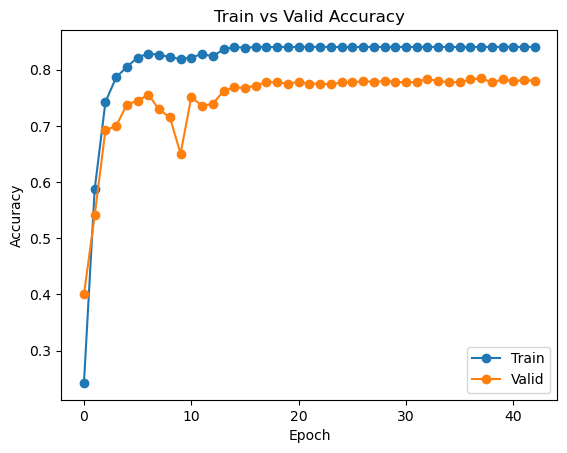

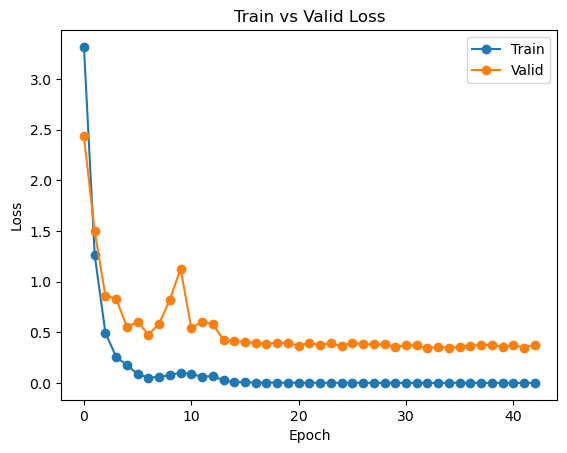

In [40]:
plot_model(resnet_accuracies, "Accuracy", "/home/avinash/Downloads/dataset/resnet_accuracy_plot.png")
plot_model(resnet_losses, "Loss", "/home/avinash/Downloads/dataset/resnet_loss_plot.png")